####Let Build our Predictive Maintenance

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

np.random.seed(42)

In [3]:
# Generate realistic vehicle data
data = pd.DataFrame({
    'vehicle_id': np.arange(1000),
    'mileage': np.random.normal(50000, 15000, 1000).astype(int),
    'age': np.random.randint(1, 8, 1000),
    'last_service_days': np.random.randint(30, 400, 1000),
    'engine_hours': np.random.normal(2000, 500, 1000).astype(int),
    'warning_lights': np.random.poisson(0.7, 1000),
    'maintenance_needed': 0  # Initialize target
})

In [4]:
# Create maintenance rules (realistic patterns)
data.loc[
    (data['mileage'] > 65000) | 
    (data['last_service_days'] > 300) |
    (data['warning_lights'] >= 2) |
    ((data['age'] > 5) & (data['engine_hours'] > 2500)),
    'maintenance_needed'
] = 1

# Add some noise (10% random flips)
flip_mask = np.random.random(1000) < 0.1
data.loc[flip_mask, 'maintenance_needed'] = 1 - data.loc[flip_mask, 'maintenance_needed']

# Export to CSV
data.to_csv('fleet_maintenance.csv', index=False)

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
# Load and preprocess
df = pd.read_csv('fleet_maintenance.csv')
features = ['mileage', 'age', 'last_service_days', 'engine_hours', 'warning_lights']
X = df[features]
y = df['maintenance_needed']

In [7]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [8]:
# Build enhanced model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

c:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Compile with class weights
neg, pos = np.bincount(y_train)
total = neg + pos
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [10]:
# Train with early stopping
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    class_weight={0: 1, 1: total/pos}  # Auto-balance
)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 188ms/step - accuracy: 0.5601 - loss: 1.7048 - precision: 0.8713 - recall: 0.1405 - val_accuracy: 0.6562 - val_loss: 0.6501 - val_precision: 0.6273 - val_recall: 0.8313
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7211 - loss: 0.8333 - precision: 0.7646 - recall: 0.6669 - val_accuracy: 0.6187 - val_loss: 0.6304 - val_precision: 0.5873 - val_recall: 0.8916
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7442 - loss: 0.7036 - precision: 0.6906 - recall: 0.8286 - val_accuracy: 0.5938 - val_loss: 0.6235 - val_precision: 0.5703 - val_recall: 0.8795
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8079 - loss: 0.6462 - precision: 0.7541 - recall: 0.8964 - val_accuracy: 0.6438 - val_loss: 0.6118 - val_precision: 0.6083 - val_recall: 0.8795
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7827 - loss: 0.6099 - precision: 0.7327 - recall: 0.8873 - val_accuracy: 0.6875 - val_loss: 

In [11]:
# Evaluate
print("\nEvaluation Metrics:")
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Evaluation Metrics:
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
              precision    recall  f1-score   support

           0       0.85      0.72      0.78        99
           1       0.76      0.87      0.81       101

    accuracy                           0.80       200
   macro avg       0.80      0.79      0.79       200
weighted avg       0.80      0.80      0.79       200

Confusion Matrix:
[[71 28]
 [13 88]]


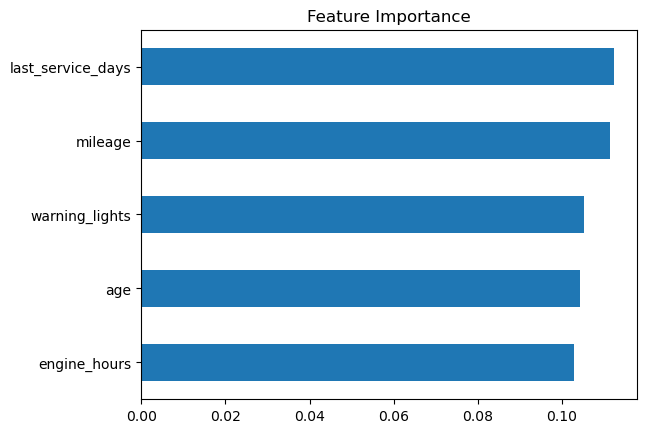

In [13]:
# Feature importance analysis
import matplotlib.pyplot as plt
weights = model.layers[0].get_weights()[0]
importance = np.mean(np.abs(weights), axis=1)
pd.Series(importance, index=features).sort_values().plot.barh()
plt.title('Feature Importance')
plt.show()